In [95]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import cv2

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [96]:
from models import GiMeFive, GiMeFiveRes
from models import SEBlock
from models import VGG16
from models import ResidualBlock, BasicBlock, ResNet, EmotionClassifierResNet18, EmotionClassifierResNet34

model = GiMeFive()
model.load_state_dict(torch.load('best_GiMeFive.pth', map_location=device))

# model = VGG16() 
# model.load_state_dict(torch.load('models/best_vgg_rafdb.pth', map_location=device))

model.eval()  

GiMeFive(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, ou

In [97]:
# img_path = 'data/valid/img416_sadness.jpg' # img496_sadness
# img_path = 'data/valid/img387_happiness.jpg' # img361_happiness, img365_happiness, img306_happiness
img_path = 'data/valid/img190_fear.jpg' # img190_fear, img114_fear
# img_path = 'data/valid/img260_disgust.jpg'# img257_disgust, img260_disgust
# img_path = 'data/valid/img582_anger.jpg' # img546_anger, img582_anger
# img_path = 'data/valid/img086_surprise.jpg' # img081_surprise, img086_surprise, img000_surprise

# img_path = 'archive/RAF-DB/train/train_00004_aligned_happiness.jpg'
# img_path = 'archive/RAF-DB/test/test_0610_aligned_sadness.jpg'
# img_path = 'archive/RAF-DB/test/test_1214_aligned_happiness.jpg'
# img_path = 'archive/RAF-DB/test/test_0294_aligned_surprise.jpg'
# img_path = 'archive/RAF-DB/test/test_1373_aligned_anger.jpg'
# img_path = 'archive/RAF-DB/test/test_2282_aligned_fear.jpg'
# img_path = 'archive/RAF-DB/test/test_0804_aligned_disgust.jpg'

img = Image.open(img_path)

def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess(img).unsqueeze(0)  
    return img

In [98]:
from hook import Hook

final_layer = model.conv5 # change here conv6 for VGG16
hook = Hook()
hook.register_hook(final_layer)

img_tensor = preprocess_image(img_path)
logits = model(img_tensor)
probabilities = F.softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)

predicted_class_idx = predicted_class.item()
print(f'Predicted class: {predicted_class_idx}')

one_hot_output = torch.FloatTensor(1, probabilities.shape[1]).zero_()
one_hot_output[0][predicted_class_idx] = 1
logits.backward(one_hot_output, retain_graph=True)

gradients = hook.backward_out
feature_maps = hook.forward_out

hook.unregister_hook()

weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
cam = torch.sum(weights * feature_maps, dim=1, keepdim=True)
cam = cam.clamp(min=0).squeeze() 

cam -= cam.min()
cam /= cam.max()
cam = cam.cpu().detach().numpy()
cam = cv2.resize(cam, (64, 64))

Predicted class: 5


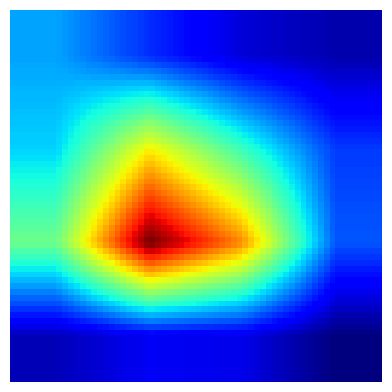

In [99]:
plt.matshow(cam, cmap='jet')
plt.axis('off')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


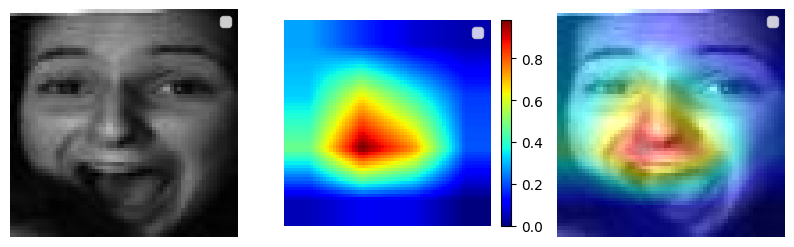

In [100]:
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
superimposed_img = heatmap*.5 + np.float32(img) / 255 # heatmap * 0.9
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 30))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.legend()

plt.subplot(1, 3, 2)
cax = plt.matshow(cam, cmap='jet', fignum=0)
plt.axis('off')
plt.colorbar(cax, ax=plt.gca(), fraction=0.045, pad=0.05)
plt.legend()

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.axis('off')
plt.legend()

plt.savefig('xai_fear.png', dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()